# Vaqmr Dashboard

In [20]:
from google.cloud import storage
from dateutil.parser import parse
import datetime
import pandas as pd
import numpy as np
import pytz

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n = 7 # n-day report

storage_client = storage.Client('dotufp')
blobs = storage_client.list_blobs('dotufp-raw')

raw_files = []
for blob in blobs:
    collector, storage_key, blob_name = blob.name.split('/')
    timestamp = parse(blob_name.split('.')[0]) # blob.time_created is tz aware
    
    today = datetime.datetime.utcnow().replace(tzinfo=pytz.utc)
    n_days_ago = today - datetime.timedelta(days=n)
    
    if blob.time_created > n_days_ago:
    
        raw_files.append({'collector': collector, 
                          'storage_key': storage_key, 
                          'timestamp': timestamp,
                          'size_bytes': blob.size})


/home/dylan/anaconda3/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
len(raw_files)

1204

In [29]:
raw_files_df = pd.DataFrame(raw_files)
# raw_files_df['cumulative_size_bytes'] = raw_files_df['size_bytes'].cumsum()

raw_files_df

,collector,storage_key,timestamp,size_bytes,cumulative_size_bytes
0,twitter_faves,dotufp,2019-11-20 00:00:07,742010,742010
1,twitter_faves,dotufp,2019-11-20 06:00:09,733467,1475477
2,twitter_faves,dotufp,2019-11-20 12:00:05,733659,2209136
3,twitter_faves,dotufp,2019-11-20 18:00:04,760310,2969446
4,twitter_faves,dotufp,2019-11-21 00:00:06,746628,3716074
...,...,...,...,...,...
1199,web_scrape,politicalwire,2019-11-26 00:00:06,56039,155065643
1200,web_scrape,politicalwire,2019-11-26 06:00:05,57067,155122710
1201,web_scrape,politicalwire,2019-11-26 07:57:18+00:00,57067,155179777
1202,web_scrape,politicalwire,2019-11-26 12:00:05+00:00,57080,155236857


In [5]:
raw_files_df.pivot_table(index=['collector', 'storage_key'], 
                         values=['storage_key', 'size_bytes'],
                         aggfunc={'storage_key': len,
                                  'size_bytes': [np.mean, sum]})

size_bytes             storage_key
                                              mean         sum         len
collector             storage_key                                         
twitter_faves         dotufp         707489.206897  20517187.0          29
twitter_home_timeline dotufp         496200.413043  45650438.0          92
twitter_timeline      mattyglesias   220748.125000  37085685.0         168
web_scrape            politicalwire   56874.618579  52040276.0         915

In [41]:
def dotufp_dashboard_chart_function(column_to_chart):
    """Initial/Temp plotting function."""
    fig, ax = plt.subplots(figsize=(15,7))
    
    list_of_collectors = ['twitter_faves', 'twitter_home_timeline', 'twitter_timeline', 'web_scrape']
    
    for collector in list_of_collectors:

        twitter_faves_df = raw_files_df[raw_files_df['collector'] == collector]
        twitter_faves_df['cumulative_size_bytes'] = twitter_faves_df['size_bytes'].cumsum()
        ax.plot(twitter_faves_df['timestamp'], twitter_faves_df[column_to_chart], label=collector)

    ax.legend()
    ax.set_title(column_to_chart)

/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


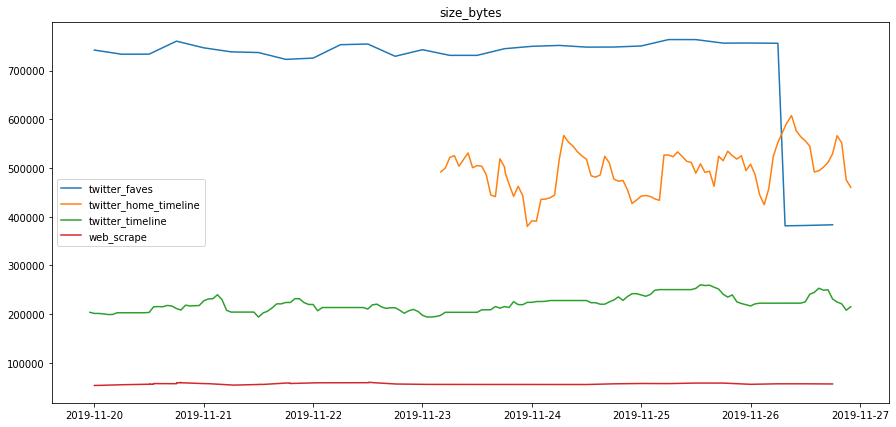

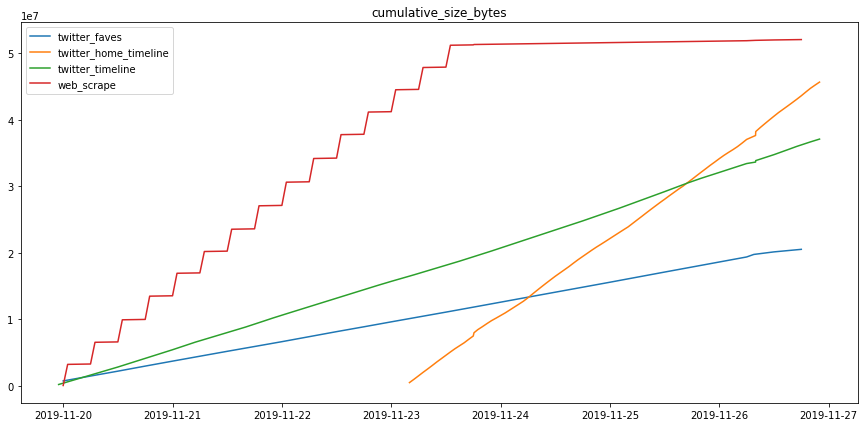

In [42]:
dotufp_dashboard_chart_function('size_bytes')
dotufp_dashboard_chart_function('cumulative_size_bytes')